In [1]:
# 📈 Análises com Python — NetBrokers

#O objetivo é realizar 3 análises sobre os dados de pedidos e clientes da NetBrokers, complementando a visualização feita no Power BI. As análises são:

# 1- Detecção de Anomalias (Outliers de Receita)
# 2- Segmentação de Clientes via RFM
# 3- Classificação ABC de Produtos

#Os dados foram tratados previamente no PostgreSQL e exportados para este ambiente para análise estatística.


In [6]:
pip install sqlalchemy psycopg2-binary


Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
from sqlalchemy import create_engine


In [ ]:
# 📦 Conexão com o Banco de Dados
# Aqui fazemos a conexão com o PostgreSQL usando SQLAlchemy para importar as tabelas do nosso modelo estrela.


In [17]:
from urllib.parse import quote_plus

# Configurações
usuario = 'postgres'
senha = quote_plus('Vs@302513')  # codifica caracteres especiais
host = 'localhost'
porta = '5432'
banco = 'teste_netbrokers'

# Criação da engine com senha codificada
engine = create_engine(f'postgresql+psycopg2://{usuario}:{senha}@{host}:{porta}/{banco}')



In [18]:
# Carrega as tabelas do banco em DataFrames
df_pedido = pd.read_sql("SELECT * FROM fato_pedido", engine)
df_item = pd.read_sql("SELECT * FROM fato_item", engine)
df_produto = pd.read_sql("SELECT * FROM dim_produto", engine)
df_cliente = pd.read_sql("SELECT * FROM dim_cliente", engine)


In [19]:
df_pedido.head()
df_pedido.info()

df_item.head()
df_item.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id_pedido        120000 non-null  object 
 1   data_pedido      120000 non-null  object 
 2   id_cliente       120000 non-null  object 
 3   canal            120000 non-null  object 
 4   uf_pedido        120000 non-null  object 
 5   estado_nome      120000 non-null  object 
 6   status           120000 non-null  object 
 7   valor_bruto      120000 non-null  float64
 8   total_descontos  120000 non-null  float64
 9   valor_liquido    120000 non-null  float64
 10  qtde_itens       120000 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 10.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240167 entries, 0 to 240166
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   

In [ ]:
# 🔍 Análise de Anomalias
#Vamos detectar os dias com receita fora do padrão utilizando o Z-Score, e depois investigar qual canal e produto geraram esse comportamento.


In [21]:
from scipy.stats import zscore

# Agrupando a receita diária
receita_dia = df_pedido.groupby('data_pedido')['valor_liquido'].sum().reset_index()
receita_dia['zscore'] = zscore(receita_dia['valor_liquido'])

# Top 3 dias mais fora do padrão (positivos ou negativos)
outliers = receita_dia.sort_values(by='zscore', key=abs, ascending=False).head(3)

# Buscando causas: canal e produto com maior impacto nesses dias
causas = []
for _, row in outliers.iterrows():
    dia = row['data_pedido']
    df_dia = df_pedido[df_pedido['data_pedido'] == dia]
    canal_top = df_dia.groupby('canal')['valor_liquido'].sum().idxmax()
    
    # Itens do dia, para ver produto destaque
    itens_dia = df_item[df_item['id_pedido'].isin(df_dia['id_pedido'])]
    produto_top = itens_dia.groupby('id_sku')['valor_liquido_item'].sum().idxmax()
    
    causas.append((canal_top, produto_top))

outliers['canal_destaque'], outliers['produto_destaque'] = zip(*causas)
outliers


,data_pedido,valor_liquido,zscore,canal_destaque,produto_destaque
927,2025-07-16,98902.10,4.525316,web,6346
117,2023-04-28,97866.17,4.386760,web,2913
499,2024-05-14,90730.88,3.432412,web,5666


In [22]:
import datetime as dt

# Convertendo datas
df_pedido['data_pedido'] = pd.to_datetime(df_pedido['data_pedido'])
data_base = df_pedido['data_pedido'].max() + pd.Timedelta(days=1)

# Calculando RFM
rfm = df_pedido.groupby('id_cliente').agg({
    'data_pedido': lambda x: (data_base - x.max()).days,  # Recency
    'id_pedido': 'count',                                 # Frequency
    'valor_liquido': 'sum'                                # Monetary
}).reset_index()

rfm.columns = ['id_cliente', 'recency', 'frequency', 'monetary']

# Pontuação RFM (quanto menor o R melhor)
rfm['pontuacao'] = (
    pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1]).astype(int) +
    pd.qcut(rfm['frequency'], 5, labels=[1,2,3,4,5]).astype(int) +
    pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5]).astype(int)
)

# Top 20 clientes com maior propensão
top_clientes = rfm.sort_values(by='pontuacao', ascending=False).head(20)
top_clientes


,id_cliente,recency,frequency,monetary,pontuacao
13312,22190,16,8,4526.09,15
29436,9966,41,10,5280.02,15
8721,17999,26,8,5680.82,15
8710,17989,11,8,5524.50,15
19140,27543,4,9,4658.98,15
19154,27556,27,8,3310.59,15
2560,12341,6,8,3686.81,15
19165,27566,14,10,3309.50,15
13240,22124,49,8,3212.45,15
13379,22251,38,8,4670.76,15


In [26]:
# Receita por SKU
abc = df_item.groupby('id_sku')['valor_liquido_item'].sum().reset_index()
abc = abc.sort_values(by='valor_liquido_item', ascending=False)
abc['participacao'] = abc['valor_liquido_item'] / abc['valor_liquido_item'].sum()
abc['acumulado'] = abc['participacao'].cumsum()

# Classificação ABC
def classificar(linha):
    if linha['acumulado'] <= 0.8:
        return 'A'
    elif linha['acumulado'] <= 0.95:
        return 'B'
    else:
        return 'C'

abc['classe'] = abc.apply(classificar, axis=1)
abc


,id_sku,valor_liquido_item,participacao,acumulado,classe
3570,4211,17022.30,0.000244,0.000244,A
5072,5564,16884.11,0.000242,0.000486,A
877,1789,16619.83,0.000238,0.000724,A
191,1170,16537.35,0.000237,0.000961,A
3761,4384,16392.20,0.000235,0.001196,A
...,...,...,...,...,...
4772,5294,3167.45,0.000045,0.999832,C
7716,7944,3106.08,0.000045,0.999876,C
2806,3524,3048.12,0.000044,0.999920,C
2869,3581,2876.88,0.000041,0.999961,C


In [ ]:
#Receita diária com outliers destacados

C:\Users\VINICIUS\AppData\Local\Temp\ipykernel_14148\2119817719.py:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\VINICIUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


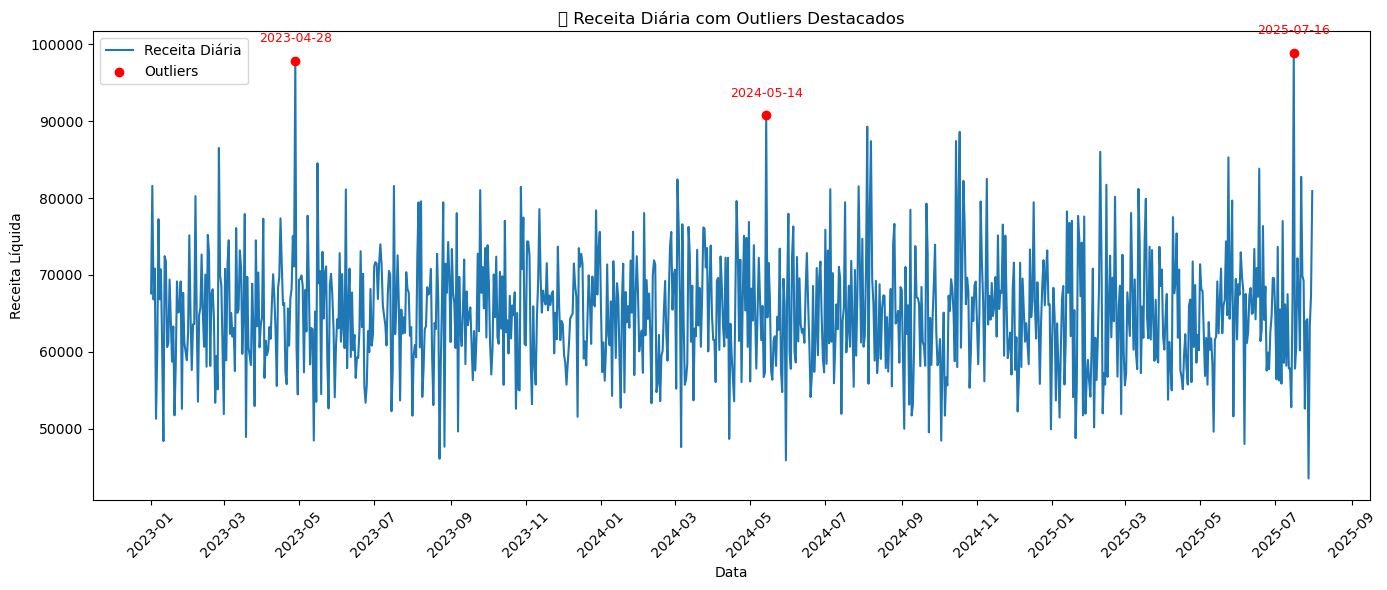

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Garantir que a data esteja em formato datetime
receita_dia['data_pedido'] = pd.to_datetime(receita_dia['data_pedido'])
outliers['data_pedido'] = pd.to_datetime(outliers['data_pedido'])

# Ordenar os dados por data, só por precaução
receita_dia = receita_dia.sort_values('data_pedido')

# Criar o gráfico
plt.figure(figsize=(14, 6))
plt.plot(receita_dia['data_pedido'], receita_dia['valor_liquido'], label='Receita Diária', linewidth=1.5)
plt.scatter(outliers['data_pedido'], outliers['valor_liquido'], color='red', label='Outliers', zorder=5)

# Adicionar rótulos nos outliers
for _, row in outliers.iterrows():
    plt.text(row['data_pedido'], row['valor_liquido'] + 2000,
             row['data_pedido'].strftime('%Y-%m-%d'),
             ha='center', va='bottom', fontsize=9, color='red')

# Títulos e eixos
plt.title('📈 Receita Diária com Outliers Destacados')
plt.xlabel('Data')
plt.ylabel('Receita Líquida')
plt.legend()

# Formatação do eixo X
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.tight_layout()

# (Opcional) Salvar o gráfico como imagem
# plt.savefig('grafico_receita_outliers.png', dpi=300, bbox_inches='tight')

# Mostrar
plt.show()





In [38]:
# Soma da receita por produto
receita_produto = df_item.groupby('id_sku')['valor_liquido_item'].sum().reset_index()

# Ordena do maior pro menor
receita_produto = receita_produto.sort_values('valor_liquido_item', ascending=False).reset_index(drop=True)

# Calcula participação % de cada SKU
receita_total = receita_produto['valor_liquido_item'].sum()
receita_produto['participacao'] = receita_produto['valor_liquido_item'] / receita_total * 100

# Calcula participação acumulada
receita_produto['participacao_acumulada'] = receita_produto['participacao'].cumsum()

# Classifica ABC com base na participação acumulada
def classificar_abc(valor):
    if valor <= 80:
        return 'A'
    elif valor <= 95:
        return 'B'
    else:
        return 'C'

receita_produto['classificacao'] = receita_produto['participacao_acumulada'].apply(classificar_abc)

# Renomeia para usar como df_abc_plot
df_abc_plot = receita_produto.copy()



C:\Users\VINICIUS\AppData\Local\Temp\ipykernel_14148\758703548.py:17: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\VINICIUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


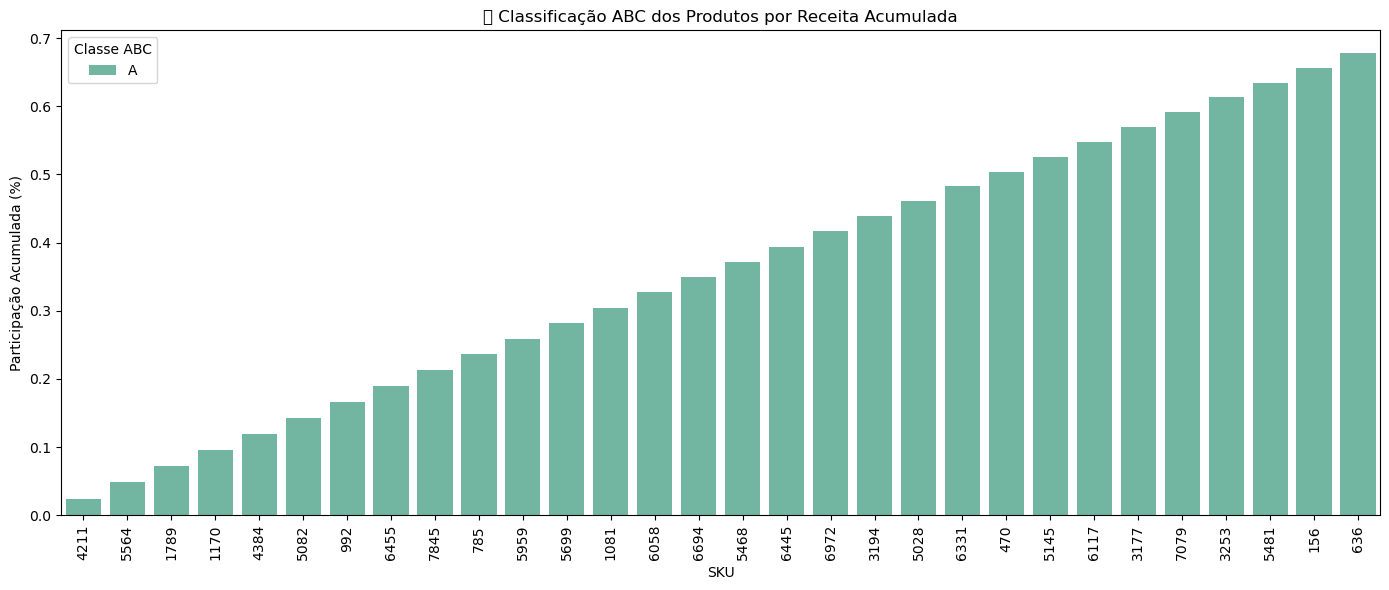

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.barplot(data=df_abc_plot.head(30),  # mostra só os 30 primeiros
            x='id_sku',
            y='participacao_acumulada',
            hue='classificacao',
            dodge=False,
            palette='Set2')

plt.title('📦 Classificação ABC dos Produtos por Receita Acumulada')
plt.xlabel('SKU')
plt.ylabel('Participação Acumulada (%)')
plt.xticks(rotation=90)
plt.legend(title='Classe ABC')
plt.tight_layout()
plt.show()


In [45]:
# Converte a data de pedido para datetime, se ainda não estiver
df_pedido['data_pedido'] = pd.to_datetime(df_pedido['data_pedido'])

# Define a data de referência como a mais recente do dataset
data_base = df_pedido['data_pedido'].max()

# Agrupa por cliente para calcular Recência, Frequência e Valor Monetário
rfm = df_pedido.groupby('id_cliente').agg({
    'data_pedido': lambda x: (data_base - x.max()).days,   # Recência
    'id_pedido': 'nunique',                                 # Frequência
    'valor_liquido': 'sum'                                  # Monetário
}).reset_index()

# Renomeia as colunas
rfm.columns = ['id_cliente', 'recencia', 'frequencia', 'valor']



In [46]:
# Score de 1 a 5 para cada métrica: quanto maior o score, melhor
rfm['r_score'] = pd.qcut(rfm['recencia'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
rfm['f_score'] = pd.qcut(rfm['frequencia'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['m_score'] = pd.qcut(rfm['valor'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Cria uma coluna final com o score total (pode ser somado ou concatenado)
rfm['rfm_score'] = rfm['r_score'] + rfm['f_score'] + rfm['m_score']


C:\Users\VINICIUS\AppData\Local\Temp\ipykernel_14148\3422368927.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_rfm, x='id_cliente', y='rfm_score', palette='crest')
C:\Users\VINICIUS\AppData\Local\Temp\ipykernel_14148\3422368927.py:14: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\VINICIUS\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


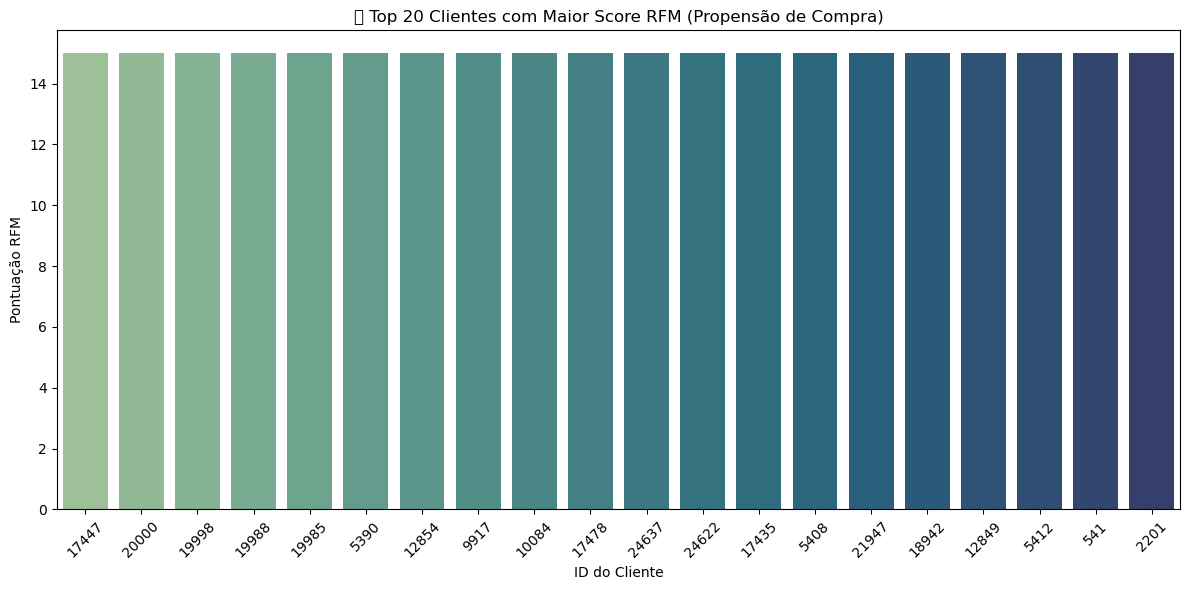

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pega os 20 maiores
top_rfm = rfm.sort_values('rfm_score', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_rfm, x='id_cliente', y='rfm_score', palette='crest')

plt.title('🏆 Top 20 Clientes com Maior Score RFM (Propensão de Compra)')
plt.xlabel('ID do Cliente')
plt.ylabel('Pontuação RFM')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Análise RFM de Segmentação de Clientes

# A Análise RFM (Recência, Frequência e Valor Monetário) ajuda a identificar os clientes mais valiosos com base em:

# Recência (R):** Há quanto tempo o cliente comprou pela última vez.
# **Frequência (F):** Quantas vezes ele comprou.
# **Monetário (M):** Quanto ele gastou no total.

# Abaixo, temos os 20 clientes com **maior propensão de compra** com base na soma do score R+F+M (quanto maior, melhor).

